# REGCOIL
This example reproduces REGCOIL results, and performs a Taylor test
that compares QUADCOIL derivatives with the results yielded by 
finite-differencing many REGCOIL results. 

This notebook requires the regcoil branch of simsopt for running 
REGCOIL and loading data. QUADCOIL itself does not depend on 
Simsopt or REGCOIL.

In [25]:
from quadcoil import quadcoil

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready
import time

In [27]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [12]:
winding_surface, plasma_surface = load('surfaces.json')
cp = CurrentPotentialFourier(
    winding_surface, mpol=4, ntor=4,
    net_poloidal_current_amperes=11884578.094260072,
    net_toroidal_current_amperes=0,
    stellsym=True)

## Solving the REGCOIL problem (automatic winding surface)
QUADCOIL inputs are strings and numpy/jax.numpy arrays. 


It only requires 
`from quadcoil import quadcoil`
unless non-default winding surface generators are required.


In [14]:
# First, test with the REGCOIL problem, auto-generating WS.
print('Running REGCOIL, with auto-generated winding surface')
regcoil1_phi_mn, regcoil1_out_dict, regcoil1_qp = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B + 0.01 f_K
    objective_name=('f_B', 'f_K'),
    objective_weight=(1., 0.01),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running REGCOIL, with auto-generated winding surface


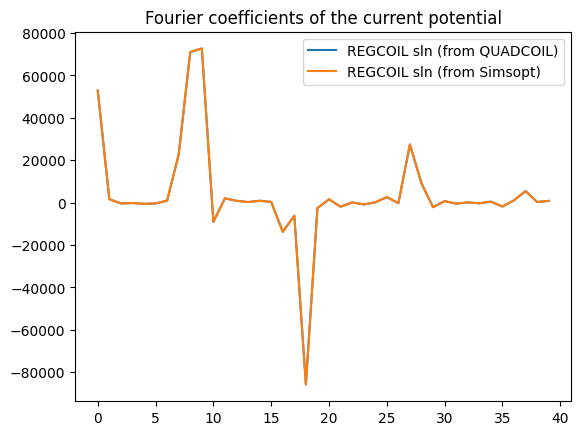

In [19]:
# Extract the winding surface and run REGCOIL
ws1 = regcoil1_qp.winding_surface.to_simsopt()
cp1 = CurrentPotentialFourier(
    ws1, mpol=cp.mpol, ntor=cp.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    stellsym=True)
cpst1 = CurrentPotentialSolve(cp1, plasma_surface, 0)
regcoil1_phi_mn_ans, regcoil1_f_B_ans, regcoil1_f_K_ans = cpst1.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()

## Running the REGCOIL problem (given winding surface)

In [22]:
# Then, test with REGCOIL, given winding surface.
print('Testing REGCOIL, with known winding surface')
regcoil2_phi_mn, regcoil2_out_dict, regcoil2_qp = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    winding_dofs=winding_surface.get_dofs(),
    winding_mpol=winding_surface.mpol,
    winding_ntor=winding_surface.ntor,
    winding_quadpoints_phi=winding_surface.quadpoints_phi,
    winding_quadpoints_theta=winding_surface.quadpoints_theta,
    objective_name=('f_B', 'f_K'),
    objective_weight=(1., 0.01),
    metric_name=('f_B', 'f_K')
)

Testing REGCOIL, with known winding surface


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


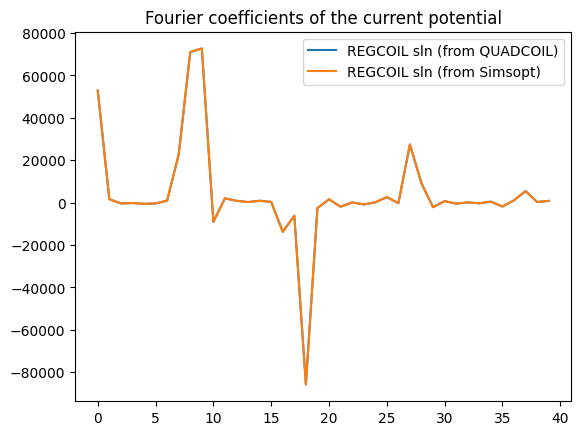

In [23]:
# Comparing with REGCOIL
cpst = CurrentPotentialSolve(cp, plasma_surface, jnp.zeros(1024))
regcoil2_phi_mn_ans, regcoil2_f_B_ans, regcoil2_f_K_ans = cpst.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()

## Taylor test
Test QUADCOIL derivatives against REGCOIL + finite difference

In [30]:
plasma_dof_orig = plasma_surface.get_dofs()
plasma_dof_0_list = []
phi_test_list = []
f_B_test_list = []
f_K_test_list = []
phi_ans_list = []
f_B_ans_list = []
f_K_ans_list = []
f_B_diff_test_list = []
f_K_diff_test_list = []
time_quadcoil_list = []
time_regcoil_list = []
for i in jnp.linspace(-0.1, 0.1, 200):
    plasma_dof_i = plasma_dof_orig.copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    regcoili_phi_mn, regcoili_out_dict, regcoili_qp = quadcoil(
        nfp=cp.nfp,
        stellsym=cp.stellsym,
        mpol=cp.mpol,
        ntor=cp.ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=cpst.plasma_surface.mpol,
        plasma_ntor=cpst.plasma_surface.ntor,
        net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
        net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
        plasma_coil_distance=plasma_surface.minor_radius(),
        objective_name=('f_B', 'f_K'),
        objective_weight=(1., 0.01),
        metric_name=('f_B', 'f_K')
    )
    block_until_ready(regcoili_phi_mn)
    block_until_ready(regcoili_out_dict)
    block_until_ready(regcoili_qp)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    # REGCOIL ---------------------------------------------------
    time1 = time.time()
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(regcoili_phi_mn)
    f_B_test_list.append(regcoili_out_dict['f_B']['value'])
    f_K_test_list.append(regcoili_out_dict['f_K']['value'])
    f_B_diff_test_list.append(regcoili_out_dict['f_B']['grad']['df_dplasma_dofs'][0])
    f_K_diff_test_list.append(regcoili_out_dict['f_K']['grad']['df_dplasma_dofs'][0])
    wsi = regcoili_qp.winding_surface.to_simsopt()
    psi = regcoili_qp.plasma_surface.to_simsopt()
    cpi = CurrentPotentialFourier(
        wsi, mpol=cp.mpol, ntor=cp.ntor,
        net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
        net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
        stellsym=True)
    cpsti = CurrentPotentialSolve(cpi, psi, 0)
    regcoili_phi_mn_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(0.01)
    time2 = time.time()
    time_regcoil_list.append(time2-time1)
    phi_ans_list.append(regcoili_phi_mn_ans)
    f_B_ans_list.append(regcoili_f_B_ans)
    f_K_ans_list.append(regcoili_f_K_ans)
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
print('REGCOIL  avg time:', np.average(time_regcoil_list), '(s)')
print('REGCOIL  max time:', np.max(time_regcoil_list), '(s)')

/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


QUADCOIL avg time: 0.9305364489555359
QUADCOIL max time: 1.2531774044036865
REGCOIL  avg time: 0.42188849329948425
REGCOIL  max time: 0.5711722373962402


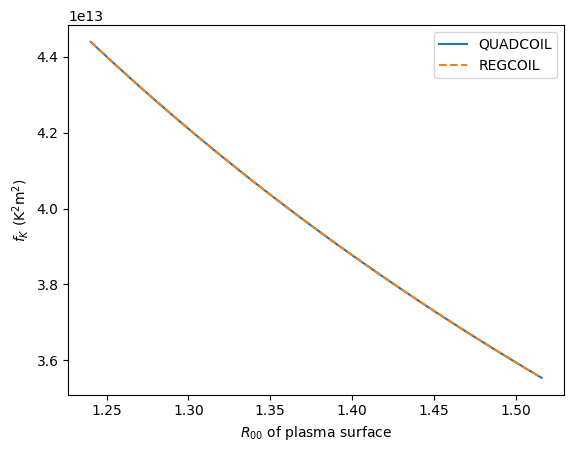

In [31]:
plt.plot(plasma_dof_0_list, f_K_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_K_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_K$ (K$^2$m$^2$)')
plt.legend()

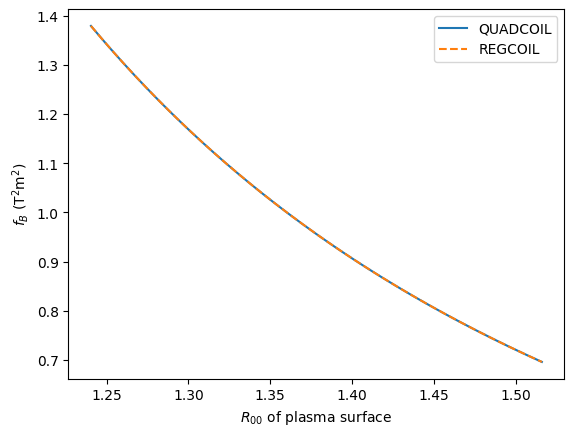

In [32]:
plt.plot(plasma_dof_0_list, f_B_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_B_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_B$ (T$^2$m$^2$)')
plt.legend()

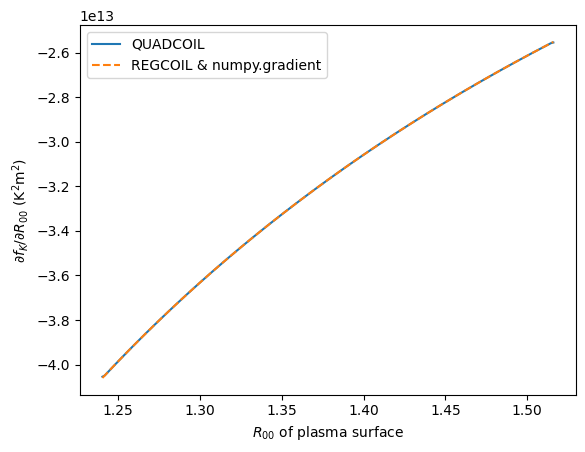

In [34]:
grad_f_K = jnp.gradient(jnp.array(f_K_test_list).flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_K, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_K_diff_test_list, label='REGCOIL & numpy.gradient', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_K/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()

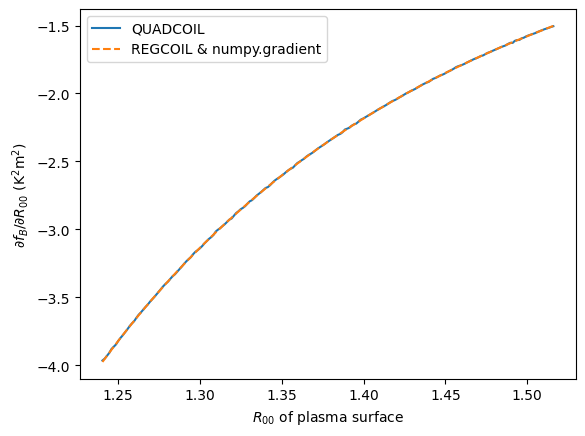

In [33]:
grad_f_B = jnp.gradient(jnp.array(f_B_test_list).flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_B, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_B_diff_test_list, label='REGCOIL & numpy.gradient', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_B/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()